## Activity scheduling simulator - Update: 29.09.21

This notebook walks through the implementation of the code. The simulator takes as input a schedule from the MTMC (the raw data is processed into a pandas dataframe with the function ```preprocess_data``` from the ```preprocessing``` module) and a travel time matrix for the visited locations and a given mode, computed using the Google Directions API. 

The assumptions as of now are the following:
* the provided schedule is treated as the individual's scheduling preferences (i.e. desired start time, duration, etc.)
* mode and location are considered known (the default mode used for the optimization is driving)

NB: As the main function of the program, only optimize_schedule is presented in detail. The code for all the other auxiliary functions is available in the respective modules (```preprocessing.py``` and ```data_utils.py```). 

### Required packages

This notebook requires the docplex package with a valid CPLEX license to run: 
https://pypi.org/project/docplex/ and https://www.ibm.com/support/knowledgecenter/SSSA5P_12.7.1/ilog.odms.cplex.help/CPLEX/GettingStarted/topics/set_up/Python_setup.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from importlib import reload
import pickle
import glob
import re
import os

from model import optimize_schedule

pd.options.display.float_format = '{:.3g}'.format

### Input data and preprocessing

The two inputs for each household (i.e. individual) are the schedule from the microcensus and a travel time matrix. The raw data is processed as to have a specific format. Each schedule contains, for each recorded activity: 
* an **id** and **label**, as defined in the MTMC, 
* a **label** for the model, 
* **start, end time** and **duration**, in hours, 
* **feasible start/end times**, in hours. 
* **location**, as a tuple (lon, lat) and a **location id** for the model,
* **categories**, either mandatory, maintenance or discretionary, 
* **flexibility profiles**, either flexible (F), moderately flexible (M) and not flexible/rigid (R)

At the moment, the feasible times, the categories and the flexibility profiles are arbitrarily defined.

An example schedule is provided for the household with ID 145440.

In [2]:
h = 145440

sched = pd.read_csv(f'example/{h}.csv')
#need to convert locations back to tuple as they get imported as strings
sched['location'] = sched.location.apply(lambda x: tuple(map(float,x[1:-1].split(','))))
sched['mode'] = 'driving' #ignore mode choice for this example 

sched['group'] = sched.loc[:, 'act_label']
sched.loc[0, 'group'] = 'dawn' #as dawn and dusk are allowed to be duplicated
sched.loc[sched.index[-1], 'group'] = 'dusk'

sched

,act_id,act_label,label,start_time,end_time,duration,feasible_start,feasible_end,location,loc_id,categories,flex_early,flex_late,flex_short,flex_long,mode,group
0,1,home,dawn,0,9.5,9.5,0,24,"(46.5356, 6.60019)",1,discret,F,M,F,F,driving,dawn
1,2,work,work1,9.53,13.5,3.97,5,23,"(46.5355, 6.59967)",0,mandat,R,R,R,M,driving,work
2,1,home,home,13.5,15.2,1.63,0,24,"(46.5356, 6.60019)",1,discret,F,M,F,F,driving,home
3,2,work,work2,15.2,20,4.8,5,23,"(46.5355, 6.59967)",0,mandat,R,R,R,M,driving,work
4,8,leisure,leisure,20.5,20.5,0,0,24,"(46.5355, 6.59967)",0,discret,F,M,F,F,driving,leisure
5,1,home,dusk,20.5,24,3.5,0,24,"(46.5356, 6.60019)",1,discret,F,M,F,F,driving,dusk


The travel time matrix is a dictionary with 2 keys (origin and destination as lon-lat tuples). The time is in hours. 

In [3]:
tt_driving = pickle.load(open(f'example/{h}_driving.pickle', "rb"))
travel_times = {'driving': tt_driving}

travel_times

{'driving': {(46.5356, 6.60019): {(46.5356, 6.60019): 0,
   (46.5355, 6.59967): 0.0002777777777777778},
  (46.5355, 6.59967): {(46.5356, 6.60019): 0.0002777777777777778,
   (46.5355, 6.59967): 0}}}

### Optimizing schedules

This section presents the implementation of the optimization model (see technical report). The full code is provided in ```model.py```.

```python
def optimize_schedule(df, travel_times, n_iter,  plot_every, mtmc = True, parameters = None, deterministic = False, plot_mode = False)```

The function takes as input:
* **df**: the dataframe containing the desired schedule (processed data)
* **travel_times**: the dataframe containing the travel times to the visited locations (processed data)
* **n_iter**: an iteration counter, useful if simulation is performed multiple times
* **plot_every**: counter for plot display - used mainly to avoid displaying every generated schedules for large numbers of iterations
* **mtmc**: for now, boolean variable that indicates if the data source is the microcensus. This was done to disable some features and constraints (e.g. duplicate activities) given the data availability. Will probably be modified or removed. 
* **parameters**: dictionary containing values for all the parameters in the model (penalties, error terms, preferences). A default set is instantiated within the function. 
* **deterministic**: boolean set to True if we are solving the problem deterministically for a given set of parameters (i.e. EV distributed term in the utility function is 0). This is ony used to compute the likelihood function for the estimation of parameters. For all other applications this should be set to False.
* **plot_mode**: boolean set to True if a graph with the mode choice should be output (experimental). Default is False. 

A **time period** argument could be added to the input, for now I am using 24h by default.

The following model components will be presented in this section: the *decision variables*, the *error term structure*, and the *output*.

The model is instantiated as a CPLEX Model object: 
```python
m = Model()```

#### 1. Decision variables 

Following the technical report, the decision variables are, for each activity $i$ and individual $n$: 
* w<sub>i</sub>: boolean variable for activity participation (1 if activity $i$ is chosen)
* x<sub>i</sub>: *continuous* variable for start time, with lower bound set to 0
* d<sub>i</sub>: *continuous* variable for duration, with lower bound set to 0
* z<sub>ij</sub>: boolean variable for activity succession between $i$ and $j$ (1 if activity $j$follows activity $i$)
* tt<sub>ij</sub>: *continuous* variable for travel time. This is not actually a decision variable in the mathematical formulation, but it is included as such in the model for simplicity. Its values are constrained to be equal to the input travel time matrix. 
* md: boolean variable for choice of mode. This variable ensures mode consistency for activity tours (experimental - only car has been included for now, but will be expanded to all private modes)

```python
x = m.continuous_var_dict(keys, lb = 0, name = 'x')
z = m.binary_var_matrix(keys, keys, name = 'z') 
d = m.continuous_var_dict(keys, lb = 0, name = 'd')
w = m.binary_var_dict(keys, name = 'w') 
tt = m.continuous_var_dict(keys, lb = 0, name = 'tt') 
md = m.binary_var_dict(keys, name = 'md') 
```

All decision variables are dictionaries. The keys are the activities labels, as defined in the input schedule. 
The input data (desired timings, locations...) are also converted to dictionaries with the same keys, using the function ```create_dicts```.

#### 2. Error term structure

**UPDATE 29/09/21: the following error structure is still implemented in the code but will be changed in the future.** As defined in the technical report, the error term has an error component structure, with one component per decision variable. Each component follows a $k$-variate normal distribution, with $k$ the possible values that the decision variable can take. For simplification, the error components of the continuous decision variables (start time and duration) have been discretized. At the moment, the correlation structure of the components has not been explored. All the error distributions have a zero mean and an identity covariance matrix. For each activity $i$ and each individual $n$, a value of the error is drawn from these distributions. In the model, this is defined as follows: 

* **Participation ($w$) and succession ($z$) errors**: 2x1 arrays of random draws from a normal distribution (2 possible values as they are binary decision variables)
* **Start time error**: 4x1 array of random draws from normal distribution. The start time has been discretized in 6h time blocks. 
* **Duration error**: 6x1 array of random draws from normal distribution. The duration has been discretized in 4h time blocks (this should be changed to a non uniform discretization, e.g. (0-30minutes, 30min-1h, 1-3h, 3 and more)
* An additional **EV distributed term**: The scale parameter has been set to 1 (and zero mean), making this equivalent to a draw from the Gumbel distribution.

At each iteration of the simulation, a new value is drawn for each component and value of the decision variable. *NB: no seed has been fixed yet.*

The error terms are included in the objective function by introducing CPLEX [piecewise functions](https://ibmdecisionoptimization.github.io/docplex-doc/mp/docplex.mp.model.html#docplex.mp.model.Model.piecewise) (```error_w```,```error_x```, ```error_d``` and ```error_z``` in the code) that act as indicator variables. These functions have been used instead of actual indicators to avoid adding constraints to the model.

```python
#objective function
m.maximize(m.sum(w[a] * ((p_st_e[flex_early[a]]) * m.max(des_start[a]-x[a], 0) 
                         + (p_st_l[flex_late[a]]) * m.max(x[a]-des_start[a], 0) 
                         +(p_dur_s[flex_short[a]]) * m.max(des_duration[a]-d[a], 0)
                         +(p_dur_l[flex_long[a]]) * m.max(d[a] - des_duration[a], 0)
                         + (p_t) * tt[a]) 
                         + error_w*w[a] + error_x*x[a] + error_d*d[a]+ m.sum(error_z*z[a,b] for b in keys) 
                         for a in keys) + np.random.gumbel())
```

#### 3. Output

If the optimization is successful, the model outputs a CPLEX solution object. A function has been written to convert this result into a pandas dataframe (```cplex_to_df```), to make it easier to plot (using ```plot_schedule``` function). 
If there is no solution, the model outputs an error message as well as a summary of the encountered conflicts. 

### Example

We can optimize the schedule of household 145440. We perform 100 iterations to see the variations of generated schedules for different values of the error term. The new error structure does not seem to have a negative impact on the solving time (for this example around 1-1.5 minutes for 100 iterations on my local machine) as compared to before, but the impact of a more accurate structure will have to be tested. 

Solving time: 65.00 seconds.


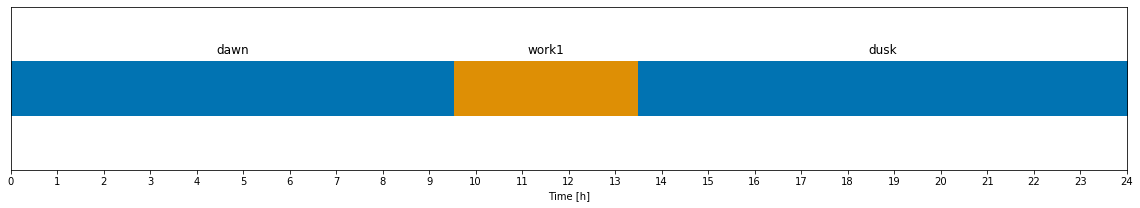

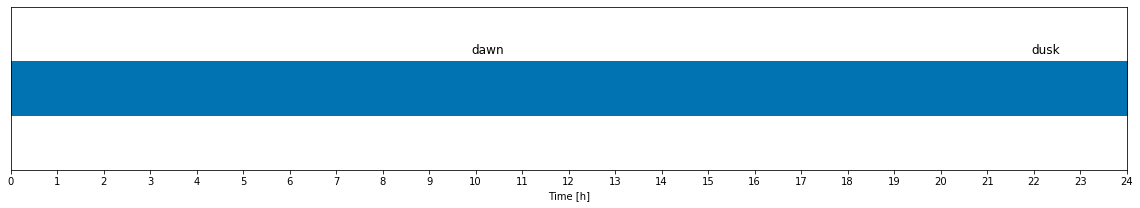

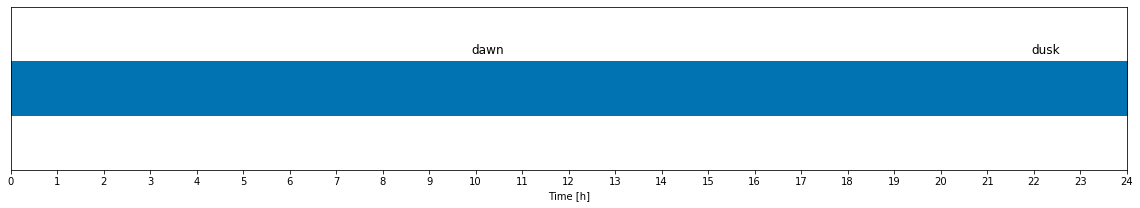

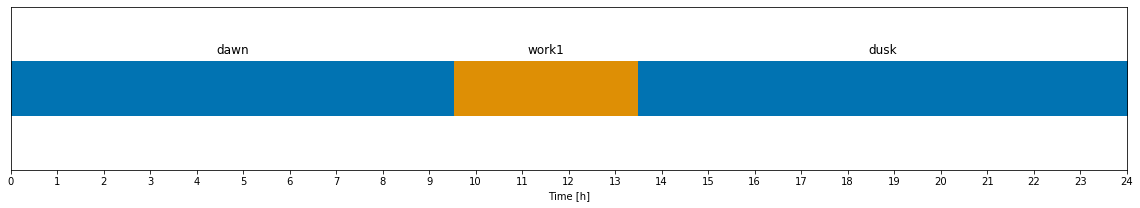

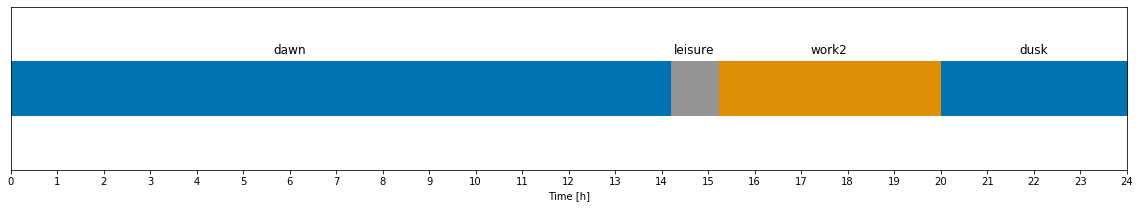

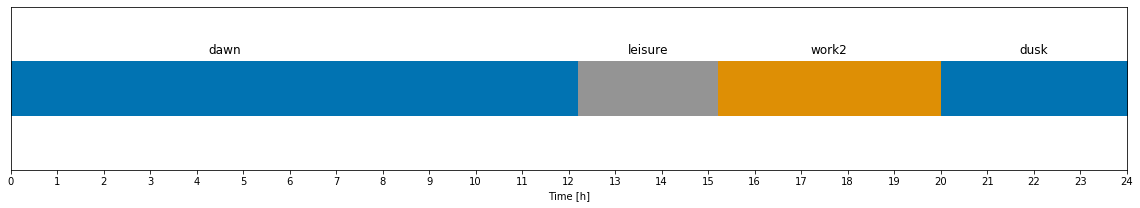

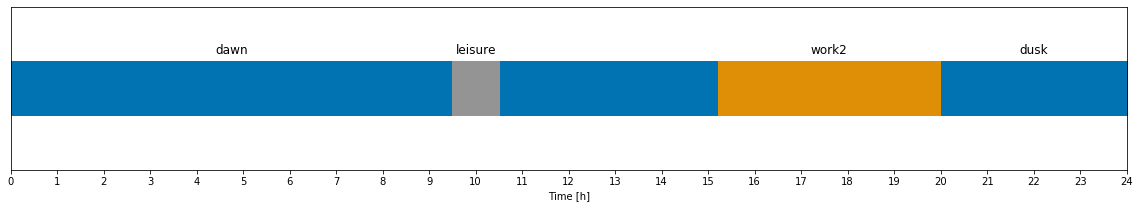

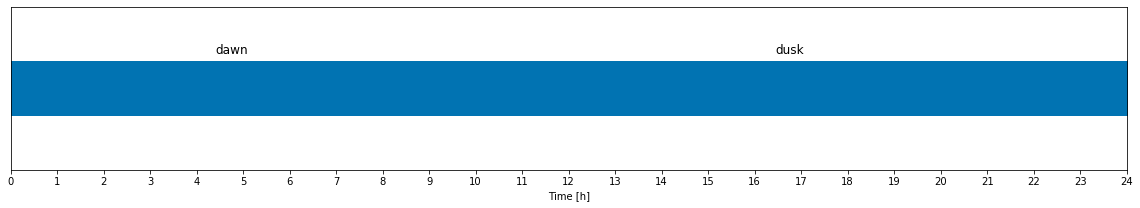

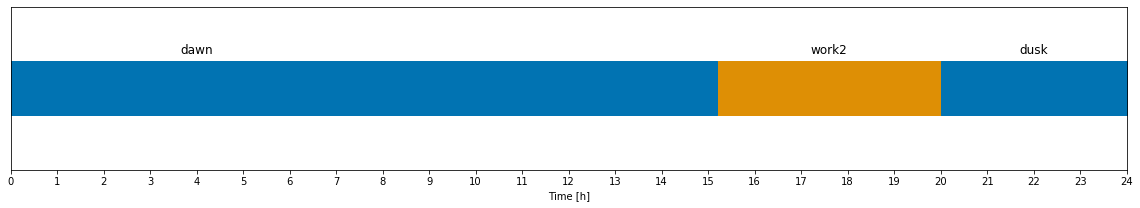

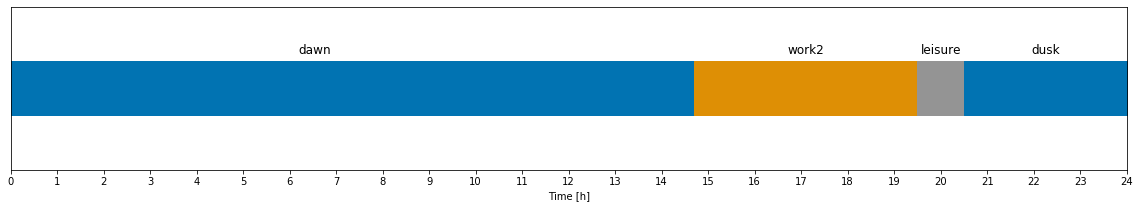

In [4]:
import time

start_time = time.time()
n = 100
n_iter = 0

for i in range(n): 
    sol, fig, _, _ = optimize_schedule(sched, travel_times,n_iter, plot_every=10)
    n_iter += 1
    
print(f"Solving time: {(time.time() - start_time):.2f} seconds.")

A solution dataframe with the same format as the input can also be produced. See below the result of the last iteration.

In [5]:
sol

,act_id,label,start_time,end_time,duration,location,mode,travel_time,car_avail
0,1,dawn,0,9.53,9.53,"(46.5356, 6.60019)",driving,0.000278,1
1,2,work1,9.53,13.5,3.97,"(46.5355, 6.59967)",driving,0.000278,1
2,1,home,13.5,15,1.5,"(46.5356, 6.60019)",driving,0.000278,1
3,8,leisure,15,16,1,"(46.5355, 6.59967)",driving,0.000278,1
4,1,dusk,16,24,8,"(46.5356, 6.60019)",driving,0,1


### Next steps

The next steps of the model development will be: 

* Improving the performance of the optimization algorihtm: implementation of techniques to speed up MILP convergence.

* Estimation of parameters, using MNL specification and choice set generated with importance sampling (Metropolis-Hastings procedure)